# Problemstellung

Eine Bank möchte die **Kreditwürdigkeit** ihrer Kunden vorhersagen.  
Auf Basis von Kundendaten (z. B. Kontostatus, Kredithistorie, Einkommen, Beschäftigung, Alter, usw.) soll ein Vorhersagemodell entwickelt werden, das jeden Kunden in eine der beiden Klassen einordnet:

- **kreditwürdig (1)**  
- **nicht kreditwürdig (2)**  

Besonderheit ist das von der Bank vorgegebene **Kostenmodell**:  

- Einen *nicht kreditwürdigen Kunden fälschlich als kreditwürdig* einzustufen, verursacht **fünfmal höhere Kosten** als den umgekehrten Fehler (*kreditwürdigen Kunden fälschlich als nicht kreditwürdig*).  

Daraus ergibt sich ein **überwachtes Klassifikationsproblem mit asymmetrischen Fehlkosten**.  

- **Zielvariable (Label):** `Creditworthy`  
- **Eingabeattribute:** Kundendaten wie  
  - Status of existing checking account  
  - Duration  
  - Credit history  
  - Purpose  
  - Credit amount  
  - Employment  
  - Job  
  - Foreign worker  
  - usw.
_________________________

### Datenbereinigung, Transformation und Begründungen

#### 1. Datenbereinigung
- Fehlende Werte (`?`) → `NaN`  
  Grund: Einheitliche Behandlung fehlender Werte; Pandas/Sklearn erwarten `NaN` für Imputation.
- Spalte `foreign_worker` entfernt  
  Grund: Proxy für Nationalität/Migration → Risiko indirekter Diskriminierung; nicht notwendig für Kreditrisikoabschätzung.

#### 2. Transformationen
- Status (aus `personal_status_sex`) → zwei Klassen  
  - Single: A93, A95  
  - Not Single: A91, A92, A94  
  - `personal_status_sex` gelöscht  
  Grund: Geschlecht entfernt (Fairness); Beziehungsstatus grob behalten (Interpretierbarkeit, weniger sensibel).

- Job → binär  
  - Unskilled: A171, A172  
  - Qualified: A173, A174, A175  
  Grund: Ursprüngliche Kategorien enthalten heikle Infos („resident vs. non-resident“); seltene Klassen fördern Overfitting.

- Purpose → 3 Klassen  
  - Consumption: A40–A44, A47  
  - Investment/Human Capital: A46, A48, A49  
  - Other/Repairs: A45, A410  
  Grund: Reduktion der Dimensionalität → stabilere Schätzungen, robustere Imputation, bessere Interpretierbarkeit.

#### 3. Ordinale Kodierung (Int64)
- savings → savings_ord: A61=1, A62=2, A63=3, A64=4, A65=0  
- checking_status → checking_status_ord: A11=1, A12=2, A13=3, A14=0  
- employment_since → employment_since_ord: A71=0, A72=1, A73=2, A74=3, A75=4  
- credit_history → credit_history_ord: A30=4, A31=3, A32=2, A33=1, A34=0  
Grund: Natürliche Rangordnung; ordinal codiert erhält Monotonie. `Int64` erlaubt `NaN`.

#### 4. One-Hot / Binär
- debtors → debtors_* (A101, A102, A103)  
- property → property_* (A121, A122, A123, A124)  
- installment_plans → instplan_* (A141, A142, A143)  
- housing → housing_* (A151, A152, A153)  
- telephone → telephone_bin (A191=0, A192=1)  
Grund: Nominalvariablen ohne Ordnung → One-Hot. Binär bei „Telefon: ja/nein“ natürlich.

#### 5. Originale nach Kodierung entfernt
`savings`, `checking_status`, `employment_since`, `credit_history`,  
`debtors`, `property`, `installment_plans`, `housing`, `telephone`,  
sowie Hilfsspalten (`*_cat`).  
Grund: Redundanz und Multikollinearität vermeiden. (Für EDA ggf. vor Drop inspizieren.)

#### 6. Vollständig numerischer Feature-Satz
- Status zusätzlich → Status_bin (Single=1, Not Single=0)  
- Purpose zusätzlich → One-Hot; danach Originale droppen  
Grund: Viele ML-Pipelines erwarten numerische Eingaben. Bei linearen Modellen ggf. Basisdroppen (`drop_first=True`).

---

#### Ergebnis
- Datensatz bereinigt  
- Sensible Merkmale reduziert/entfernt  
- Kategorien verdichtet und kodiert  

Effekte: stabileres Training, geringeres Overfitting, robustere Imputation, bessere Nachvollziehbarkeit.


In [48]:
import pandas as pd

# === Pfad zur Datendatei anpassen ===
FILE_PATH = "kredit.dat"     # z.B. "/mnt/data/kredit.dat"
SAVE_CSV = True
CSV_PATH = "kredit_clean.csv"

# Spaltennamen gemäß Datensatz
colnames = [
    "checking_status",           # A11-A14
    "duration_months",
    "credit_history",            # A30-A34
    "purpose",                   # A40-A410
    "credit_amount",
    "savings",                   # A61-A65
    "employment_since",          # A71-A75
    "installment_rate_pct",
    "personal_status_sex",       # A91-A95
    "debtors",                   # A101-A103
    "residence_since",
    "property",                  # A121-A124
    "age_years",
    "installment_plans",         # A141-A143
    "housing",                   # A151-A153
    "existing_credits",
    "job",                       # A171-A175 (incomplete)
    "dependents",
    "telephone",                 # A191-A192
    "foreign_worker",            # A201-A202 (incomplete)
    "target"                     # 1 = good, 2 = bad (je nach Quelle)
]

# 1) Einlesen & fehlende Werte als NaN erfassen
df = pd.read_csv(
    FILE_PATH,
    sep=r"\s+",
    header=None,
    names=colnames,
    na_values=["?"]
)

# 2) 'foreign_worker' aus ethischen Gründen löschen
if "foreign_worker" in df.columns:
    df = df.drop(columns=["foreign_worker"])

# 3) personal_status_sex -> Status (Single vs. Not Single)
status_map = {"A93": "Single", "A95": "Single", "A91": "Not Single", "A92": "Not Single", "A94": "Not Single"}
df["Status"] = df["personal_status_sex"].map(status_map).astype("category")
df = df.drop(columns=["personal_status_sex"], errors="ignore")

# 4) Job -> binär (Unskilled vs. Qualified) als Kategorie (NaN bleibt NaN)
unskilled = {"A171", "A172"}
qualified = {"A173", "A174", "A175"}
def job_to_binary(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in unskilled: return "Unskilled"
    if code in qualified: return "Qualified"
    return pd.NA
df["job"] = df["job"].apply(job_to_binary).astype("category")

# 5) Purpose -> 3 Stufen (NaN bleibt NaN)
consumption = {"A40", "A41", "A42", "A43", "A44", "A47"}
investment = {"A46", "A48", "A49"}
other_repairs = {"A45", "A410"}
def purpose_to_coarse(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in consumption: return "Consumption"
    if code in investment: return "Investment/Human Capital"
    if code in other_repairs: return "Other/Repairs"
    return pd.NA
df["purpose"] = df["purpose"].apply(purpose_to_coarse).astype("category")

# 6) Ordinale Kodierung (NaN -> <NA> via Int64)
df["savings_ord"]            = df["savings"].map({"A61":1,"A62":2,"A63":3,"A64":4,"A65":0}).astype("Int64")
df["checking_status_ord"]    = df["checking_status"].map({"A11":1,"A12":2,"A13":3,"A14":0}).astype("Int64")
df["employment_since_ord"]   = df["employment_since"].map({"A71":0,"A72":1,"A73":2,"A74":3,"A75":4}).astype("Int64")
df["credit_history_ord"]     = df["credit_history"].map({"A30":4,"A31":3,"A32":2,"A33":1,"A34":0}).astype("Int64")

# 7) One-Hot / binär mit NaN-Durchreichung
def one_hot_with_nan(source_series: pd.Series, prefix: str) -> pd.DataFrame:
    """Erzeugt One-Hot-Dummies in Int64 und setzt bei NaN in der Quelle
    die gesamte Dummy-Zeile auf <NA>, statt auf 0."""
    dums = pd.get_dummies(source_series, prefix=prefix, dtype="Int64")
    mask = source_series.isna()
    if mask.any():
        dums.loc[mask, :] = pd.NA
        # Sicherheits-Recast (stellt sicher, dass Int64 erhalten bleibt):
        dums = dums.astype("Int64")
    return dums

# debtors
df["debtors_cat"] = df["debtors"].map({"A101":"none","A102":"co_applicant","A103":"guarantor"})
df = pd.concat([df, one_hot_with_nan(df["debtors_cat"], "debtors")], axis=1)

# property
df["property_cat"] = df["property"].map({"A121":"Immobilien","A122":"Versicherung","A123":"Auto","A124":"None"})
df = pd.concat([df, one_hot_with_nan(df["property_cat"], "property")], axis=1)

# installment plans
df["installment_plans_cat"] = df["installment_plans"].map({"A141":"bank","A142":"stores","A143":"none"})
df = pd.concat([df, one_hot_with_nan(df["installment_plans_cat"], "instplan")], axis=1)

# housing
df["housing_cat"] = df["housing"].map({"A151":"rent","A152":"own","A153":"free"})
df = pd.concat([df, one_hot_with_nan(df["housing_cat"], "housing")], axis=1)

# telephone (NaN bleibt NaN)
df["telephone_bin"] = df["telephone"].map({"A191":0,"A192":1}).astype("Int64")

# 8) Verbindlich: numerischer Satz für Status & Purpose (mit NaN-Durchreichung)
# Status -> binär (NaN bleibt NaN)
df["Status_bin"] = df["Status"].map({"Single":1, "Not Single":0}).astype("Int64")

# purpose -> One-Hot (NaN bleibt NaN in allen purpose_* Spalten)
purpose_dummies = one_hot_with_nan(df["purpose"], "purpose")
df = pd.concat([df, purpose_dummies], axis=1)

# Optional: job zusätzlich numerisch (NaN bleibt NaN)
df["job_bin"] = df["job"].map({"Unskilled":0, "Qualified":1}).astype("Int64")

# 9) Jetzt ALLE Original-Kategorien in EINEM Schritt droppen
drop_cols = [
    "savings","checking_status","employment_since","credit_history",
    "debtors","property","installment_plans","housing","telephone",
    "debtors_cat","property_cat","installment_plans_cat","housing_cat",
    "Status","purpose","job"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 10) Ausgabe & Speichern
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
print(df.head(10).to_string(index=False))

if SAVE_CSV:
    df.to_csv(CSV_PATH, index=False)
    print(f"\nGespeichert als: {CSV_PATH}")


 duration_months  credit_amount  installment_rate_pct  residence_since  age_years  existing_credits  dependents  target  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
              36           2299                     4                4         39                 1           1       1            3                    0                  <NA>                   2                     0                  0             1              1                    0              0                      0              0              1                0             0            1             0              0           1                 <NA>             

### Explorative Visualisierung numerischer Variablen

Für jede ausgewählte numerische Variable werden zwei Diagramme erstellt:

- **Histogramm** zur Untersuchung der Verteilung (inkl. Dichtekurve)  
- **Boxplot** zur Identifikation möglicher Ausreißer  

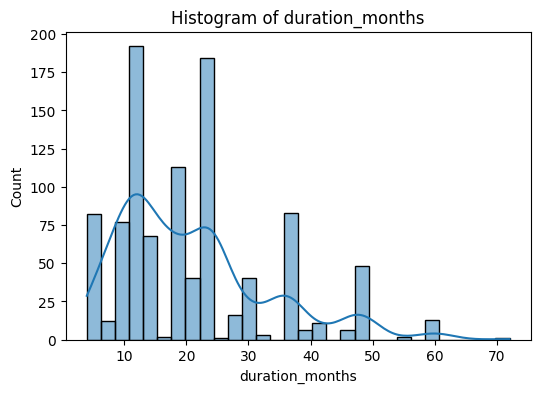

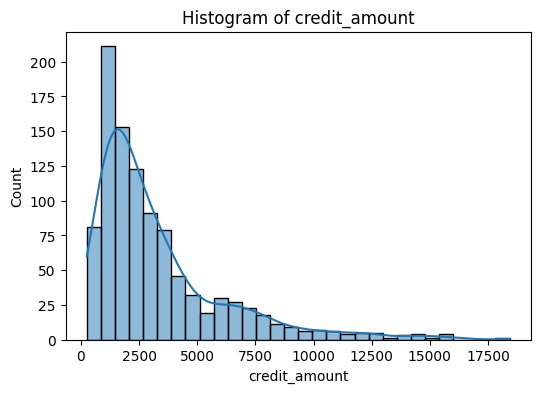

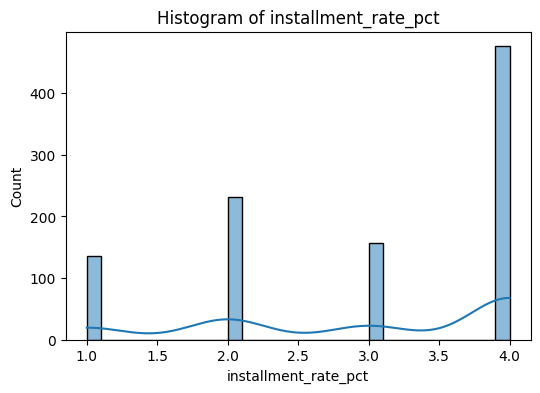

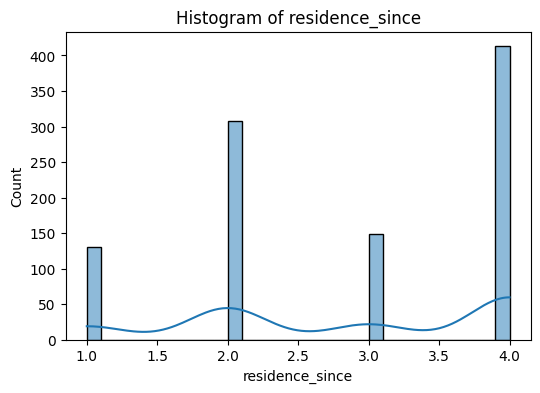

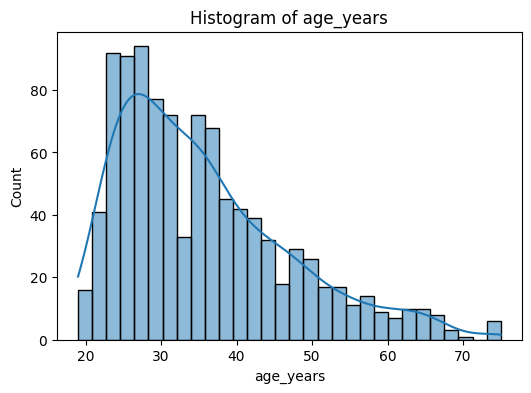

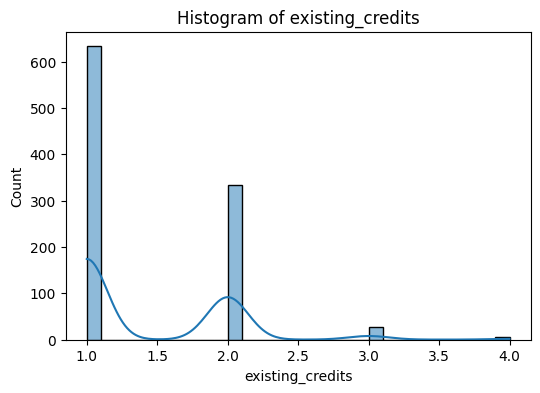

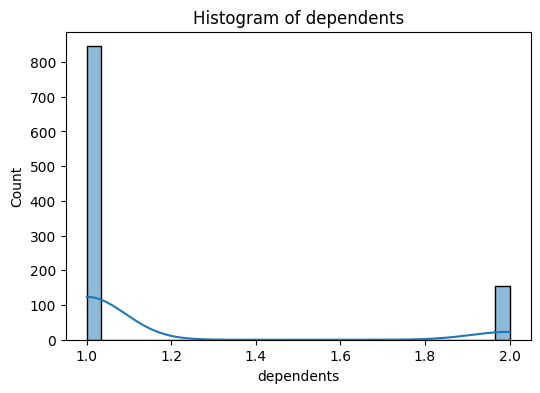

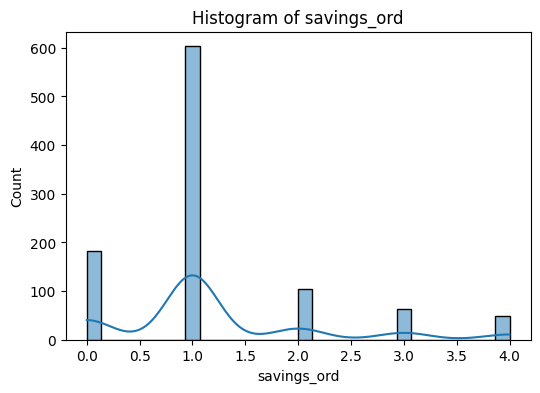

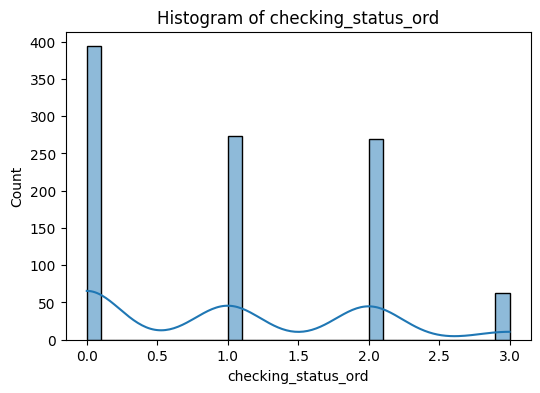

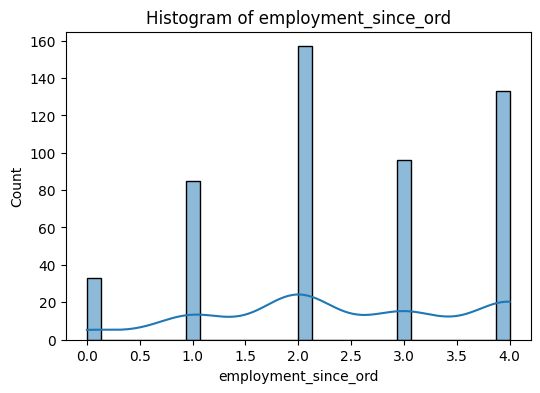

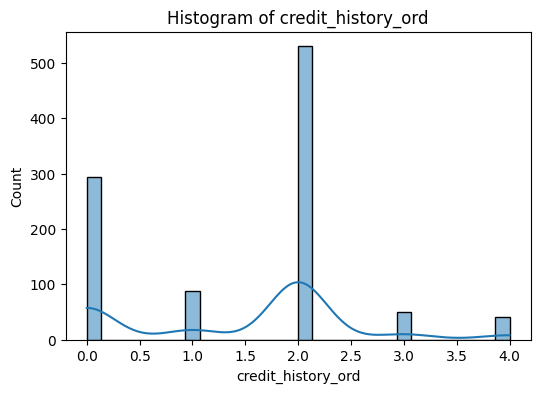

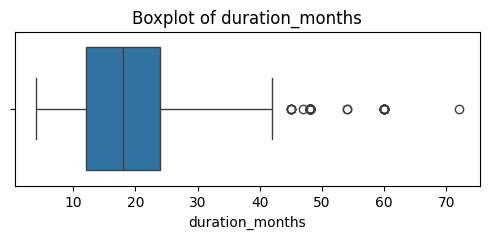

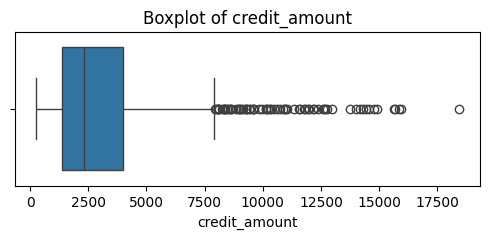

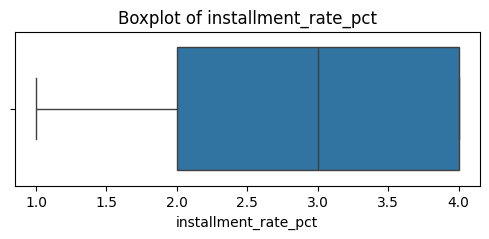

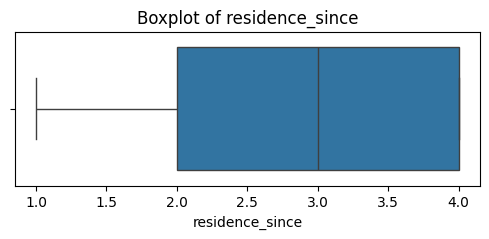

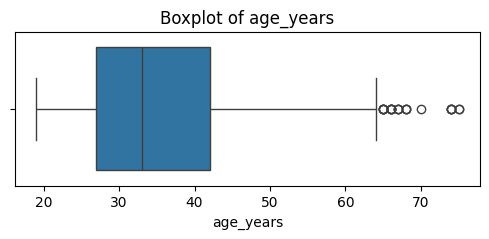

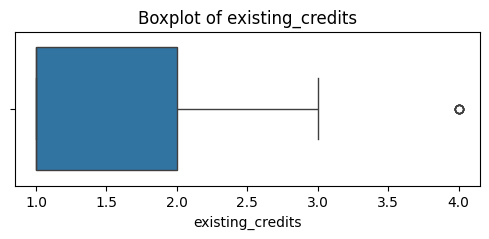

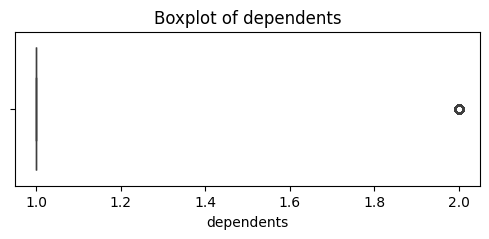

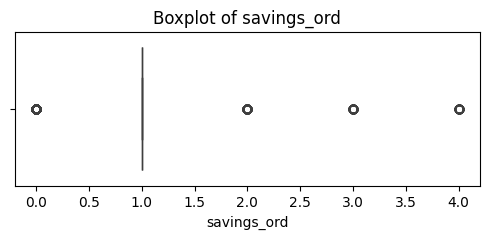

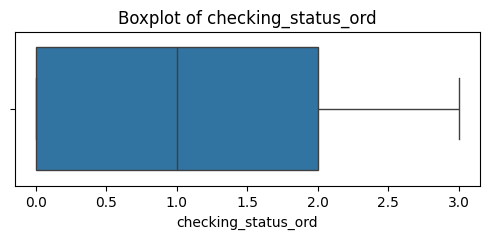

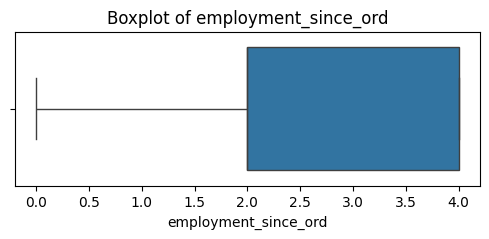

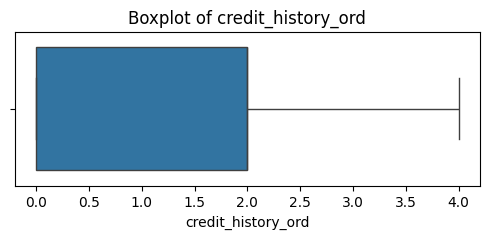

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der Spalten, die normalisiert werden könnten
numeric_cols = [
    "duration_months",
    "credit_amount",
    "installment_rate_pct",
    "residence_since",
    "age_years",
    "existing_credits",
    "dependents",
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord"
]

# Histogramme für jede Variable
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.show()

# Boxplots um Ausreißer zu erkennen
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.show()

### Datenvorverarbeitung

- CSV-Datei `kredit_clean.csv` wird geladen.  
- Spalten werden nach Typen gruppiert:
  - **Robust-Skalierung** für `credit_amount`  
  - **Standard-Skalierung** für kontinuierliche und ordinale Variablen  
  - **Binäre Variablen** bleiben unverändert  

- Mit einem `ColumnTransformer` werden die Skalierungen angewendet.  
- Ergebnis ist ein neuer DataFrame mit skalierten Werten, der wieder mit dem Original kombiniert wird.  

So entsteht ein einheitlich vorbereiteter Datensatz für das Modell.


In [49]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# CSV laden
df = pd.read_csv("kredit_clean.csv")

# Spalten definieren
robust_cols = ["credit_amount"]

standard_cont_cols = [
    "duration_months",
    "age_years",
    "installment_rate_pct",
    "residence_since",
    "existing_credits",
    "dependents",
]

standard_ordinal_cols = [
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord",
]

binary_cols = [
    "debtors_co_applicant", "debtors_guarantor", "debtors_none",
    "property_Auto", "property_Immobilien", "property_None", "property_Versicherung",
    "instplan_bank", "instplan_none", "instplan_stores",
    "housing_free", "housing_own", "housing_rent",
    "telephone_bin", "Status_bin",
    "purpose_Consumption", "purpose_Investment/Human Capital", "purpose_Other/Repairs",
    "job_bin",
]

used_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols
X = df[used_cols].copy()

# Pipelines ohne Imputer -> NaN bleibt erhalten
robust_num = Pipeline(steps=[
    ("scale", RobustScaler())
])

standard_cont = Pipeline(steps=[
    ("scale", StandardScaler())
])

standard_ordinal = Pipeline(steps=[
    ("scale", StandardScaler())
])

passthrough_bin = "passthrough"

# ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ("robust_num", robust_num, robust_cols),
    ("standard_cont", standard_cont, standard_cont_cols),
    ("standard_ordinal", standard_ordinal, standard_ordinal_cols),
    ("bin", passthrough_bin, binary_cols),
], remainder="drop")

# Fit & Transform
X_scaled = preprocess.fit_transform(X)

# DataFrame mit Spaltennamen
scaled_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols
X_scaled_df = pd.DataFrame(X_scaled, columns=scaled_cols, index=df.index)

# Wieder ins Original einbauen (target bleibt unberührt)
df = pd.concat([df.drop(columns=scaled_cols), X_scaled_df], axis=1)

print(df.head(10).to_string(index=False))


 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463                   NaN            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  NaN             

In [50]:
# Anzahl fehlender Werte je Spalte
missing_counts = df.isna().sum()

# Anteil in Prozent
missing_percent = (df.isna().mean() * 100).round(2)

# Zusammenführen in ein DataFrame
missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print(missing_summary.to_string())

                                  missing_count  missing_percent
target                                        0              0.0
credit_amount                                 0              0.0
duration_months                               0              0.0
age_years                                     0              0.0
installment_rate_pct                          0              0.0
residence_since                               0              0.0
existing_credits                              0              0.0
dependents                                    0              0.0
savings_ord                                   0              0.0
checking_status_ord                           0              0.0
employment_since_ord                        496             49.6
credit_history_ord                            0              0.0
debtors_co_applicant                          0              0.0
debtors_guarantor                             0              0.0
debtors_none             

### Imputation Pipeline (Purpose, Job, Employment)

Dieses Skript ersetzt fehlende Werte (`NaN`) in den Spalten **Purpose**, **Job** und **Employment** durch Modelle:

- **Purpose**: Multinomiale logistische Regression (balanced, Scoring: Precision + Accuracy) → Rückschreiben in Dummy-Spalten.  
- **Job**: Binäre logistische Regression (balanced, Scoring: Precision + Accuracy) → Ergänzung von `job_bin`.  
- **Employment**: Lineare Regression (Ridge, mit CV) → Rundung und Clipping auf Kategorien 0–4.  

**Evaluation**: Nested Cross-Validation mit passenden Metriken.  

**Ergebnisse**:  
- Purpose: Precision ≈ 0.75 | Accuracy ≈ 0.84  
- Job: Precision ≈ 0.80 | Accuracy ≈ 0.70  
- Employment: MAE ≈ 0.57 | Ordinal Accuracy ≈ 0.64  

Die Modelle liefern stabile Ergebnisse für die Imputation.


In [51]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.metrics import mean_absolute_error

# ======================================================================
# Konfiguration
# ======================================================================
RANDOM_STATE = 42
OUTER_FOLDS = 10
BIG_C = 1e10                      # ~keine Regularisierung für LogReg (L2)
C_GRID_EMP = [0.1, 1.0, 10.0]     # für Employment -> alpha_grid = 1/C
ALPHA_GRID_EMP = [1.0 / c for c in C_GRID_EMP]

# ======================================================================
# Hilfsfunktionen
# ======================================================================
def clip_round(arr, low=0, high=4):
    arr = np.rint(arr)
    return np.clip(arr, low, high).astype(int)

def ordinal_acc(y_true, y_pred_cont, low=0, high=4):
    yp = clip_round(y_pred_cont, low, high)
    return (yp == y_true.astype(int)).mean()

def assert_no_nan(df_like, name="X"):
    bad = df_like.isna().sum()
    if hasattr(bad, "sum"):
        tot = int(bad.sum())
        assert tot == 0, f"{name} enthält {tot} NaNs:\n{bad[bad>0].sort_values(ascending=False).head(15)}"
    else:
        assert not np.isnan(df_like).any(), f"{name} enthält NaNs."

# ======================================================================
# 0) Datensatz: Annahme df existiert bereits
# ======================================================================
TARGET_COL = "target" if "target" in df.columns else None

purpose_cols = [
    "purpose_Consumption",
    "purpose_Investment/Human Capital",
    "purpose_Other/Repairs",
]

# ======================================================================
# 1) PURPOSE imputieren (multinomiale LogReg ~ohne Regularisierung), zurück in Original-Dummies
# ======================================================================

# Robuste Ableitung von 'purpose_cat'
P = df[purpose_cols].astype(float)
row_sum = P.fillna(0).sum(axis=1)
valid = (row_sum == 1)
print(f"[PURPOSE] Zeilen ohne Label (alles 0/NaN): {int((row_sum == 0).sum())}")
print(f"[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: {int((row_sum > 1).sum())}")

df["purpose_cat"] = pd.Series(pd.NA, index=df.index, dtype="object")
df.loc[valid, "purpose_cat"] = P.loc[valid].idxmax(axis=1)
mask_purpose = df["purpose_cat"].notna()

# Features/Labels (nur bekannte purpose_cat)
exclude_for_purpose = purpose_cols + ["purpose_cat", "employment_since_ord", "job_bin"]
if TARGET_COL:
    exclude_for_purpose.append(TARGET_COL)
X_purpose = df.loc[mask_purpose, [c for c in df.columns if c not in exclude_for_purpose]]
y_purpose = df.loc[mask_purpose, "purpose_cat"]

assert_no_nan(X_purpose, "X_purpose")
assert_no_nan(y_purpose.to_frame(), "y_purpose")

# Multinomiale LogReg mit lbfgs, l2, riesiges C -> praktisch unregularisiert
logreg_multi = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,
    max_iter=2000,
    class_weight=None,           # Fokus auf Precision
    random_state=RANDOM_STATE
)

outer_cv_p = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Reporting: Precision (weighted) + Accuracy
scoring_purpose = {"precision_weighted": "precision_weighted", "accuracy": "accuracy"}
cvres_p = cross_validate(logreg_multi, X_purpose, y_purpose, cv=outer_cv_p,
                         scoring=scoring_purpose, n_jobs=-1)
print(
    "[PURPOSE] 10-fold CV  precision_weighted: "
    f"{cvres_p['test_precision_weighted'].mean():.3f} ± {cvres_p['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_p['test_accuracy'].mean():.3f} ± {cvres_p['test_accuracy'].std():.3f}"
)

# Finale Purpose-Imputation
logreg_multi.fit(X_purpose, y_purpose)
if df["purpose_cat"].isna().any():
    X_purpose_missing = df.loc[~mask_purpose, X_purpose.columns]
    assert_no_nan(X_purpose_missing, "X_purpose_missing")
    df.loc[~mask_purpose, "purpose_cat"] = logreg_multi.predict(X_purpose_missing)

# Zurück in die ursprünglichen Dummy-Spalten
df.loc[:, purpose_cols] = 0
for cat in df["purpose_cat"].dropna().unique():
    df.loc[df["purpose_cat"] == cat, cat] = 1
df.drop(columns=["purpose_cat"], inplace=True)
assert_no_nan(df[purpose_cols], "purpose dummy cols")

# ======================================================================
# 2) JOB imputieren (binäre LogReg ~ohne Regularisierung, aber class_weight='balanced')
# ======================================================================
mask_job = df["job_bin"].notna().astype(bool)
exclude_for_job = ["job_bin", "employment_since_ord"]
if TARGET_COL:
    exclude_for_job.append(TARGET_COL)
X_job_cols = [c for c in df.columns if c not in exclude_for_job]
X_job = df.loc[mask_job, X_job_cols]
y_job = df.loc[mask_job, "job_bin"].astype(int)

assert_no_nan(X_job, "X_job")
assert_no_nan(y_job.to_frame(), "y_job")

outer_cv_j = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

logreg_bin = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,                      # praktisch keine Regularisierung
    max_iter=2000,
    class_weight="balanced",      # hilft bei Imbalance (ohne Laufzeitkosten)
    random_state=RANDOM_STATE
)

scoring_job = {
    "precision_weighted": "precision_weighted",
    "accuracy": "accuracy",
}
cvres_j = cross_validate(logreg_bin, X_job, y_job, cv=outer_cv_j,
                         scoring=scoring_job, n_jobs=-1)
print(
    "[JOB] 10-fold CV  precision_weighted: "
    f"{cvres_j['test_precision_weighted'].mean():.3f} ± {cvres_j['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_j['test_accuracy'].mean():.3f} ± {cvres_j['test_accuracy'].std():.3f}"
)

# Finale Job-Imputation
logreg_bin.fit(X_job, y_job)
if df["job_bin"].isna().any():
    X_job_missing = df.loc[~mask_job, X_job_cols]
    assert_no_nan(X_job_missing, "X_job_missing")
    df.loc[~mask_job, "job_bin"] = logreg_bin.predict(X_job_missing)

assert df["job_bin"].isna().sum() == 0, "job_bin hat noch Missing-Werte."

# ======================================================================
# 3) EMPLOYMENT imputieren (RidgeCV mit kleinem Alpha-Grid), Reporting MAE & OrdAcc
# ======================================================================
mask_emp = df["employment_since_ord"].notna().astype(bool)
exclude_for_emp = ["employment_since_ord"]
if TARGET_COL:
    exclude_for_emp.append(TARGET_COL)
X_emp_cols = [c for c in df.columns if c not in exclude_for_emp]
X_emp = df.loc[mask_emp, X_emp_cols]
y_emp = df.loc[mask_emp, "employment_since_ord"]

assert_no_nan(X_emp, "X_emp")
assert_no_nan(y_emp.to_frame(), "y_emp")

outer_cv_e = KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
mae_list, ordacc_list = [], []
for tr_idx, te_idx in outer_cv_e.split(X_emp):
    Xtr, Xte = X_emp.iloc[tr_idx], X_emp.iloc[te_idx]
    ytr, yte = y_emp.iloc[tr_idx], y_emp.iloc[te_idx]

    ridge_cv = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5)
    ridge_cv.fit(Xtr, ytr)
    ypred = ridge_cv.predict(Xte)

    mae_list.append(mean_absolute_error(yte, ypred))
    ordacc_list.append(ordinal_acc(yte.values, ypred, low=0, high=4))

print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV MAE: mean={np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV Ordinal-Accuracy: mean={np.mean(ordacc_list):.3f} ± {np.std(ordacc_list):.3f}")

# Finale Imputation mit bestem alpha auf allen bekannten Daten
ridge_cv_full = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5)
ridge_cv_full.fit(X_emp, y_emp)
best_alpha = ridge_cv_full.alpha_
best_C_emp = 1.0 / best_alpha
print(f"[EMPLOYMENT] Best alpha={best_alpha:.6g} -> Best C≈{best_C_emp:.6g}")

if df["employment_since_ord"].isna().any():
    X_emp_missing = df.loc[~mask_emp, X_emp_cols]
    assert_no_nan(X_emp_missing, "X_emp_missing")
    emp_pred = ridge_cv_full.predict(X_emp_missing)
    df.loc[~mask_emp, "employment_since_ord"] = clip_round(emp_pred, low=0, high=4)

# Final sanity checks
assert df[purpose_cols].isna().sum().sum() == 0, "Purpose-Dummies haben NaNs."
assert df["job_bin"].isna().sum() == 0, "job_bin hat NaNs."
assert df["employment_since_ord"].isna().sum() == 0, "employment_since_ord hat NaNs."

print("✓ Imputation abgeschlossen.")


[PURPOSE] Zeilen ohne Label (alles 0/NaN): 173
[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: 0
[PURPOSE] 10-fold CV  precision_weighted: 0.679 ± 0.028 | acc: 0.810 ± 0.012


c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[JOB] 10-fold CV  precision_weighted: 0.765 ± 0.054 | acc: 0.663 ± 0.055
[EMPLOYMENT] 10-fold CV MAE: mean=0.748 ± 0.074
[EMPLOYMENT] 10-fold CV Ordinal-Accuracy: mean=0.574 ± 0.053
[EMPLOYMENT] Best alpha=10 -> Best C≈0.1
✓ Imputation abgeschlossen.


In [52]:
print(df.head(10).to_string(index=False))
df.to_csv("kredit_clean.csv", index=False)

 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463              1.000000            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  1.0             

### Feature-Correlation-Analyse

Dieses Skript untersucht die Beziehungen zwischen Merkmalen und Zielvariable:

1. **Korrelation mit Ziel**
   - Pearson & Spearman Korrelationen
   - Schwach korrelierte Features werden markiert

2. **Multikollinearität**
   - Erkennung stark korrelierter Features
   - Empfehlung, welche zu behalten/entfernen

3. **Feature Importance**
   - ANOVA F-Score und Mutual Information
   - Identifikation statistisch schwacher Merkmale

4. **Empfehlungen**
   - Liste von Features zum Behalten oder Entfernen
   - Erstellung eines optimierten Datensatzes

5. **Visualisierung**
   - Top-Korrelationen
   - Top-Features nach Wichtigkeit
   - Scatterplot (Korrelation vs. Wichtigkeit)
   - Übersicht Keep/Drop

➡️ Ergebnis: Ein optimierter Datensatz mit reduzierten und relevanten Features.


Starting comprehensive feature correlation analysis...
FEATURE CORRELATION ANALYSIS FOR BANKING MODEL
Dataset: 1000 samples, 30 features
Target distribution: 700 good (70.0%) / 300 bad (30.0%)

1. CORRELATION WITH TARGET (minimum threshold: 0.05)
--------------------------------------------------
Top correlations with target (Pearson):
                 feature  pearson_corr  pearson_p_value
10    credit_history_ord     -0.228785     2.423060e-13
1        duration_months     -0.214927     6.488050e-12
8    checking_status_ord     -0.197788     2.804819e-10
0          credit_amount     -0.154739     8.797572e-07
22           housing_own      0.134589     1.953064e-05
16         property_None     -0.125750     6.679290e-05
15   property_Immobilien      0.119300     1.559643e-04
9   employment_since_ord      0.116517     2.220048e-04
19         instplan_none      0.113285     3.313488e-04
18         instplan_bank     -0.096510     2.248844e-03

WEAK FEATURES (correlation < 0.05):
  existin

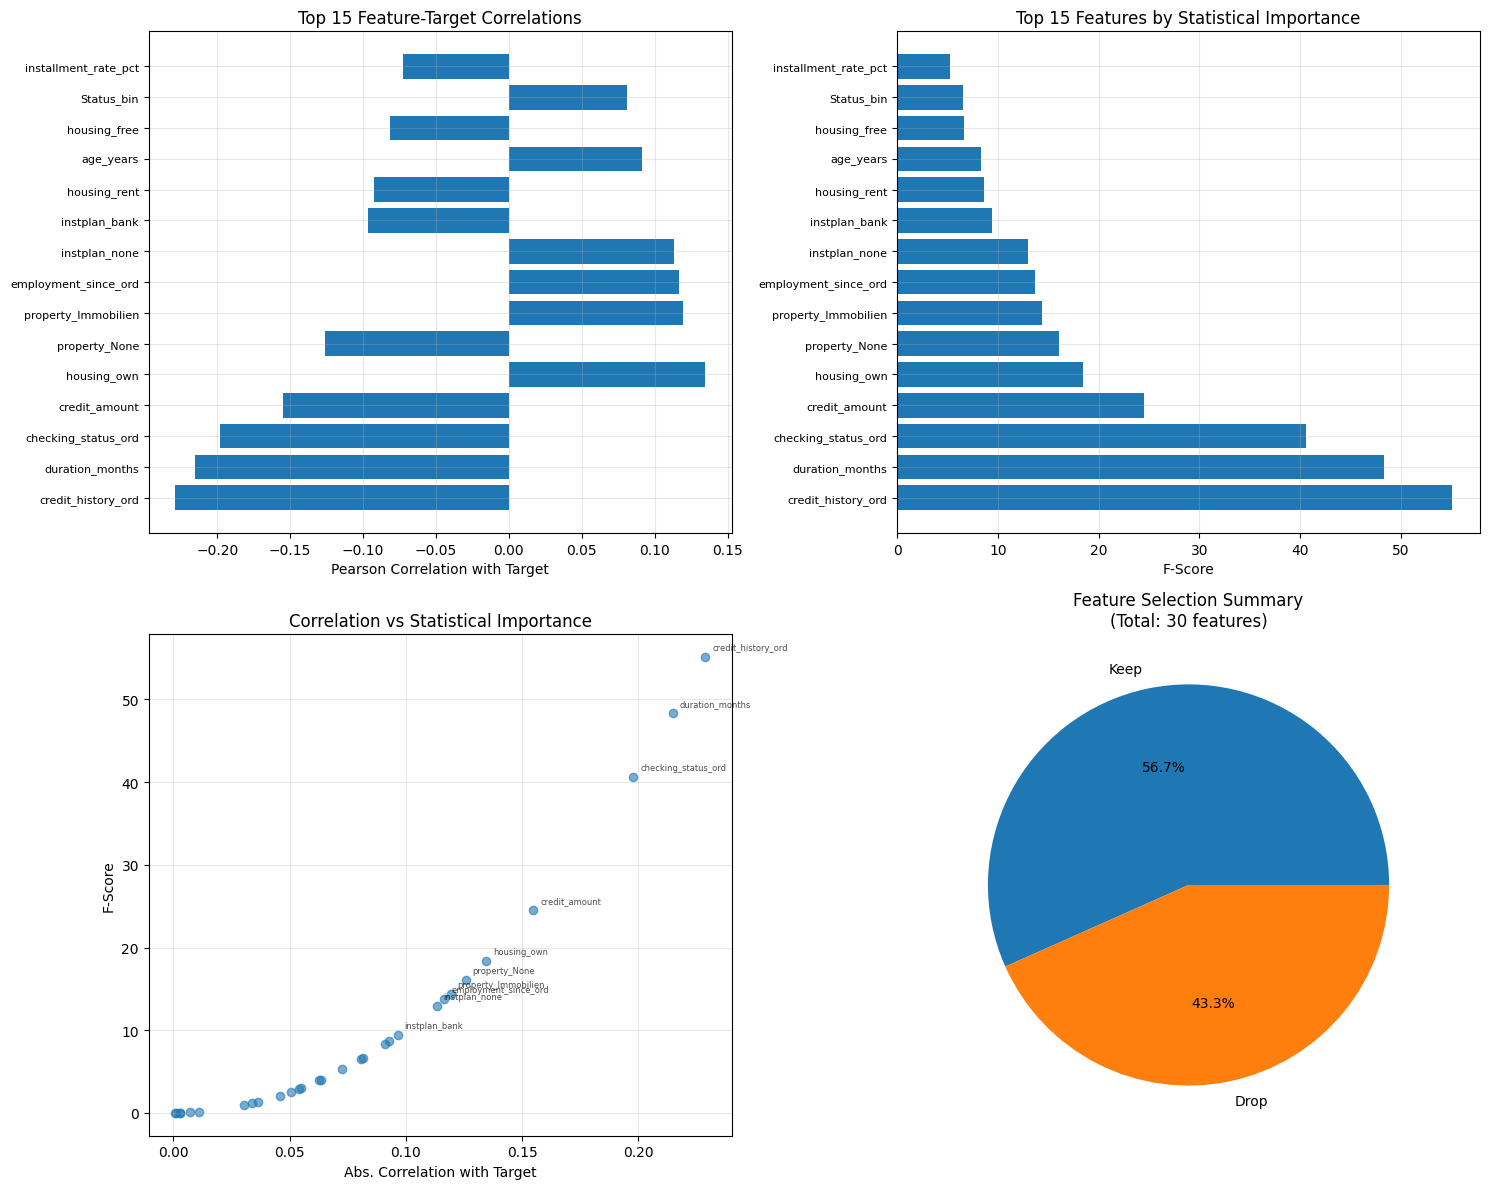


Optimized dataset ready with 17 features!
             feature   f_score    f_p_value  mutual_info
  credit_history_ord 55.123045 2.423060e-13     0.015704
     duration_months 48.333790 6.488050e-12     0.029212
 checking_status_ord 40.631200 2.804819e-10     0.056012
       credit_amount 24.482366 8.797572e-07     0.013559
         housing_own 18.411417 1.953064e-05     0.002018
       property_None 16.035010 6.679290e-05     0.000000
 property_Immobilien 14.408984 1.559643e-04     0.000000
employment_since_ord 13.735514 2.220048e-04     0.025089
       instplan_none 12.974369 3.313488e-04     0.000000
       instplan_bank  9.382968 2.248844e-03     0.000000


In [53]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def analyze_feature_correlations(df, target_col='target', threshold_high=0.9, threshold_target=0.05):
    # Prepare data
    y = (df[target_col] == 1).astype(int).values
    # keep only numeric features for stats below
    X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()

    print("FEATURE CORRELATION ANALYSIS FOR BANKING MODEL")
    print("=" * 60)
    print(f"Dataset: {len(df)} samples, {len(X.columns)} features")
    print(f"Target distribution: {y.sum()} good ({y.mean():.1%}) / {len(y)-y.sum()} bad ({1-y.mean():.1%})")

    results = {}

    # 1) Target correlations
    print(f"\n1. CORRELATION WITH TARGET (minimum threshold: {threshold_target})")
    print("-" * 50)

    target_correlations = []
    for col in X.columns:
        x = X[col].values
        # Guard against constant columns
        if np.all(x == x[0]):
            pearson_corr, pearson_p = 0.0, 1.0
            spearman_corr, spearman_p = 0.0, 1.0
        else:
            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)

        target_correlations.append({
            'feature': col,
            'pearson_corr': pearson_corr,
            'pearson_p_value': pearson_p,
            'spearman_corr': spearman_corr,
            'spearman_p_value': spearman_p,
            'abs_pearson': abs(pearson_corr),
            'abs_spearman': abs(spearman_corr)
        })

    target_corr_df = pd.DataFrame(target_correlations).sort_values('abs_pearson', ascending=False)
    print("Top correlations with target (Pearson):")
    print(target_corr_df[['feature', 'pearson_corr', 'pearson_p_value']].head(10))

    weak_features = target_corr_df[target_corr_df['abs_pearson'] < threshold_target]['feature'].tolist()
    print(f"\nWEAK FEATURES (correlation < {threshold_target}):")
    for feature in weak_features:
        corr_val = target_corr_df.loc[target_corr_df['feature'] == feature, 'pearson_corr'].iloc[0]
        print(f"  {feature}: {corr_val:.4f}")

    results['target_correlations'] = target_corr_df
    results['weak_features'] = weak_features

    # 2) Multicollinearity
    print(f"\n2. MULTICOLLINEARITY ANALYSIS (threshold: {threshold_high})")
    print("-" * 50)

    corr_matrix = X.corr(numeric_only=True).abs()
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val >= threshold_high:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                col1_target_corr = abs(target_corr_df.loc[target_corr_df['feature'] == col1, 'pearson_corr'].iloc[0])
                col2_target_corr = abs(target_corr_df.loc[target_corr_df['feature'] == col2, 'pearson_corr'].iloc[0])
                recommend_drop, recommend_keep = (col2, col1) if col1_target_corr > col2_target_corr else (col1, col2)
                high_corr_pairs.append({
                    'feature1': col1, 'feature2': col2, 'correlation': corr_val,
                    'feature1_target_corr': col1_target_corr, 'feature2_target_corr': col2_target_corr,
                    'recommend_drop': recommend_drop, 'recommend_keep': recommend_keep
                })

    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        print("HIGH CORRELATIONS BETWEEN FEATURES:")
        for _, row in high_corr_df.iterrows():
            print(f"  {row['feature1']} <-> {row['feature2']}: {row['correlation']:.3f}")
            print(f"    Target correlations: {row['feature1_target_corr']:.3f} vs {row['feature2_target_corr']:.3f}")
            print(f"    RECOMMENDATION: Drop {row['recommend_drop']}, Keep {row['recommend_keep']}\n")
        results['multicollinear_features'] = list({p['recommend_drop'] for p in high_corr_pairs})
        results['high_corr_pairs'] = high_corr_df
    else:
        print("No high correlations found between features.")
        results['multicollinear_features'] = []

    # 3) Feature importance
    print(f"\n3. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    selector_f = SelectKBest(score_func=f_classif, k='all').fit(X_scaled, y)
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all').fit(X_scaled, y)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector_f.scores_,
        'f_p_value': selector_f.pvalues_,
        'mutual_info': selector_mi.scores_
    }).sort_values('f_score', ascending=False)

    print("Top features by F-score:")
    print(feature_importance[['feature', 'f_score', 'f_p_value']].head(10))

    low_importance_features = feature_importance[feature_importance['f_p_value'] > 0.05]['feature'].tolist()
    results['feature_importance'] = feature_importance
    results['low_importance_features'] = low_importance_features

    # 4) Final recommendations
    print(f"\n4. FEATURE SELECTION RECOMMENDATIONS")
    print("-" * 50)
    features_to_drop = set(weak_features) | set(results['multicollinear_features']) | set(low_importance_features)
    features_to_keep = [c for c in X.columns if c not in features_to_drop]

    print(f"FEATURES TO DROP ({len(features_to_drop)}):")
    if features_to_drop:
        for f in sorted(features_to_drop):
            reasons = []
            if f in weak_features: reasons.append("weak target correlation")
            if f in results['multicollinear_features']: reasons.append("multicollinearity")
            if f in low_importance_features: reasons.append("low statistical importance")
            print(f"  {f}: {', '.join(reasons)}")
    else:
        print("  None")

    print(f"\nFEATURES TO KEEP ({len(features_to_keep)}):")
    for f in sorted(features_to_keep):
        tc = target_corr_df.loc[target_corr_df['feature'] == f, 'pearson_corr'].iloc[0]
        fs = feature_importance.loc[feature_importance['feature'] == f, 'f_score'].iloc[0]
        print(f"  {f}: target_corr={tc:.3f}, f_score={fs:.1f}")

    results['features_to_drop'] = list(features_to_drop)
    results['features_to_keep'] = features_to_keep

    # 5) Optimized dataset
    df_optimized = df[features_to_keep + [target_col]].copy()
    print(f"\nOPTIMIZED DATASET:")
    print(f"  Original: {df.shape[1]-1} features")
    print(f"  Optimized: {len(features_to_keep)} features")
    print(f"  Reduction: {(df.shape[1]-1) - len(features_to_keep)} features removed")

    results['optimized_dataframe'] = df_optimized
    return results

def plot_correlation_analysis(results, figsize=(15, 12)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    target_corr_df = results['target_correlations'].head(15)
    axes[0,0].barh(range(len(target_corr_df)), target_corr_df['pearson_corr'])
    axes[0,0].set_yticks(range(len(target_corr_df)))
    axes[0,0].set_yticklabels(target_corr_df['feature'], fontsize=8)
    axes[0,0].set_xlabel('Pearson Correlation with Target')
    axes[0,0].set_title('Top 15 Feature-Target Correlations')
    axes[0,0].grid(True, alpha=0.3)

    feature_imp = results['feature_importance'].head(15)
    axes[0,1].barh(range(len(feature_imp)), feature_imp['f_score'])
    axes[0,1].set_yticks(range(len(feature_imp)))
    axes[0,1].set_yticklabels(feature_imp['feature'], fontsize=8)
    axes[0,1].set_xlabel('F-Score')
    axes[0,1].set_title('Top 15 Features by Statistical Importance')
    axes[0,1].grid(True, alpha=0.3)

    merge_df = results['target_correlations'].merge(results['feature_importance'], on='feature')
    axes[1,0].scatter(merge_df['abs_pearson'], merge_df['f_score'], alpha=0.6)
    axes[1,0].set_xlabel('Abs. Correlation with Target')
    axes[1,0].set_ylabel('F-Score')
    axes[1,0].set_title('Correlation vs Statistical Importance')
    axes[1,0].grid(True, alpha=0.3)
    for _, row in merge_df.head(10).iterrows():
        axes[1,0].annotate(row['feature'], (row['abs_pearson'], row['f_score']),
                           xytext=(5,5), textcoords='offset points', fontsize=6, alpha=0.7)

    n_total = len(results['target_correlations'])
    n_keep = len(results['features_to_keep'])
    n_drop = len(results['features_to_drop'])
    axes[1,1].pie([n_keep, n_drop], labels=['Keep', 'Drop'], autopct='%1.1f%%')
    axes[1,1].set_title(f'Feature Selection Summary\n(Total: {n_total} features)')

    plt.tight_layout()
    plt.show()
    return fig

def analyze_and_optimize_features(df, target_col='target', **kwargs):
    """Wrapper: analyze correlations, plot, and return optimized dataset & results."""
    results = analyze_feature_correlations(df, target_col=target_col, **kwargs)
    plot_correlation_analysis(results)
    return results['optimized_dataframe'], results

# --- Usage ---
print("Starting comprehensive feature correlation analysis...")
optimized_df, analysis_results = analyze_and_optimize_features(df, target_col='target')

# Keep artifacts, then intentionally overwrite working df
features_kept     = analysis_results['features_to_keep']
features_dropped  = analysis_results['features_to_drop']
df = optimized_df.copy()
df.to_csv("kredit_final.csv", index=False)

print(f"\nOptimized dataset ready with {df.shape[1]-1} features!")
print(analysis_results['feature_importance'].head(10).to_string(index=False))

### Optimal Banking Model (kurz)

**Ziel**  
GradientBoosting-Modell trainieren und nur **sichere Vorhersagen** (Confidence ≥ 0.85) automatisch treffen.

**Vorgehen**  
- Daten aufteilen: `X` (Features), `y` (1=good, 0=bad).  
- **GridSearchCV** (AUC) für GradientBoosting-Hyperparameter.  
- **Confidence-Filter**: nur p ≥ 0.85 oder p ≤ 0.15 → automatisieren; sonst `-1` = manuelle Prüfung.  
- **Bewertung** (nur sichere Fälle): Accuracy, Balanced Accuracy, ROC-AUC, Confusion-Matrix, **Kosten 5×FP + 1×FN**.  
- **Cross-Validation** zur Leistungsprüfung.  
- **Speichern/Laden** des Modells mit `joblib`.  
- **Business Summary**: automatisierter Anteil, erwartete Genauigkeit, Kosten, FP/FN.

**Wichtigste Funktionen**  
- `train_with_hyperparameter_tuning(X, y)`: Training + beste Parameter.  
- `predict_with_confidence(X)`: Vorhersagen mit Coverage & Mask.  
- `evaluate_model(X_test, y_test)`: Metriken nur für sichere Fälle.  
- `cross_validate_performance(X, y)`: CV-Ergebnisse + Zusammenfassung.  
- `save_model(path)` / `load_model(path)`: Persistenz.  
- `get_business_summary(X, y)`: kompakter Business-Report.  
- `train_optimal_banking_model(df)`: **End-to-End**-Workflow.

**Output**  
- Trainiertes Pipeline-Modell mit Threshold 0.85  
- CV-Übersicht (Accuracy, Coverage, Kosten)  
- Business-Impact (Automatisierung vs. manuell)


In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

class ConfidentBankingModel:
    def __init__(self, confidence_threshold=0.8, min_coverage=0.3):
        """
        confidence_threshold: Minimum probability to make a prediction (0.8 = 80%)
        min_coverage: Minimum fraction of cases we must be able to predict
        """
        self.confidence_threshold = confidence_threshold
        self.min_coverage = min_coverage
        self.models = {}
        
    def evaluate_with_confidence(self, model, X_test, y_test):
        """Evaluate model only on high-confidence predictions"""
        # Get probability predictions
        if hasattr(model, 'predict_proba'):
            probas = model.predict_proba(X_test)[:, 1]
        else:
            # For models without predict_proba, use decision_function
            scores = model.decision_function(X_test)
            probas = 1 / (1 + np.exp(-scores))  # Sigmoid transform
        
        # Find high-confidence predictions
        high_confidence_mask = (probas >= self.confidence_threshold) | (probas <= (1 - self.confidence_threshold))
        
        if np.sum(high_confidence_mask) == 0:
            return {
                'coverage': 0.0,
                'confident_accuracy': 0.0,
                'confident_balanced_accuracy': 0.0,
                'confident_auc': 0.0,
                'total_samples': len(X_test),
                'confident_samples': 0,
                'confident_predictions': np.array([]),
                'confident_true_labels': np.array([]),
                'all_probabilities': probas
            }
        
        # Get confident predictions
        X_confident = X_test[high_confidence_mask]
        y_confident = y_test[high_confidence_mask]
        probas_confident = probas[high_confidence_mask]
        
        # Make predictions for confident cases
        predictions_confident = (probas_confident >= 0.5).astype(int)
        
        # Calculate metrics only for confident predictions
        coverage = np.sum(high_confidence_mask) / len(X_test)
        confident_accuracy = accuracy_score(y_confident, predictions_confident)
        confident_balanced_accuracy = balanced_accuracy_score(y_confident, predictions_confident)
        
        # AUC only if we have both classes in confident predictions
        if len(np.unique(y_confident)) > 1:
            confident_auc = roc_auc_score(y_confident, probas_confident)
        else:
            confident_auc = np.nan
            
        # Calculate confusion matrix
        if len(y_confident) > 0:
            conf_matrix = confusion_matrix(y_confident, predictions_confident)
        else:
            conf_matrix = None
            
        return {
            'coverage': coverage,
            'confident_accuracy': confident_accuracy,
            'confident_balanced_accuracy': confident_balanced_accuracy,
            'confident_auc': confident_auc,
            'total_samples': len(X_test),
            'confident_samples': np.sum(high_confidence_mask),
            'confident_predictions': predictions_confident,
            'confident_true_labels': y_confident,
            'all_probabilities': probas,
            'confusion_matrix': conf_matrix
        }
    
    def cross_validate_with_confidence(self, X, y, model_configs, cv_folds=5):
        """Cross-validation with confidence-based evaluation"""
        
        results = []
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        for model_name, model_config in model_configs.items():
            print(f"\nEvaluating {model_name} with confidence threshold {self.confidence_threshold}")
            
            fold_results = []
            
            for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Grid search for best parameters
                grid_search = GridSearchCV(
                    model_config['pipeline'],
                    model_config['param_grid'],
                    cv=3,
                    scoring='roc_auc',
                    n_jobs=-1
                )
                
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                
                # Evaluate with confidence
                confidence_results = self.evaluate_with_confidence(best_model, X_test, y_test.values)
                
                fold_result = {
                    'model': model_name,
                    'fold': fold,
                    'coverage': confidence_results['coverage'],
                    'confident_accuracy': confidence_results['confident_accuracy'],
                    'confident_balanced_accuracy': confidence_results['confident_balanced_accuracy'],
                    'confident_auc': confidence_results['confident_auc'],
                    'total_samples': confidence_results['total_samples'],
                    'confident_samples': confidence_results['confident_samples'],
                    'best_params': grid_search.best_params_
                }
                
                # Calculate cost function for confident predictions only
                if confidence_results['confusion_matrix'] is not None and confidence_results['confusion_matrix'].size == 4:
                    tn, fp, fn, tp = confidence_results['confusion_matrix'].ravel()
                    cost_5xFP_1xFN = 5 * fp + 1 * fn
                    fold_result['confident_cost_5xFP_1xFN'] = cost_5xFP_1xFN
                    fold_result['confident_FP'] = fp
                    fold_result['confident_FN'] = fn
                else:
                    fold_result['confident_cost_5xFP_1xFN'] = np.nan
                    fold_result['confident_FP'] = np.nan
                    fold_result['confident_FN'] = np.nan
                
                fold_results.append(fold_result)
                
                print(f"  Fold {fold}: Coverage={confidence_results['coverage']:.3f}, "
                      f"Confident Accuracy={confidence_results['confident_accuracy']:.3f}, "
                      f"Samples={confidence_results['confident_samples']}/{confidence_results['total_samples']}")
            
            results.extend(fold_results)
        
        return pd.DataFrame(results)
    
    def get_model_configs(self):
        """Define model configurations"""
        return {
            'LogisticRegression': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42, max_iter=1000))
                ]),
                'param_grid': {
                    'clf__C': [0.01, 0.1, 1, 10, 100],
                    'clf__penalty': ['l1', 'l2'],
                    'clf__solver': ['liblinear']
                }
            },
            'GBDT_LightGBM': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', lgb.LGBMClassifier(random_state=42, verbose=-1))
                ]),
                'param_grid': {
                    'clf__n_estimators': [100, 200],
                    'clf__learning_rate': [0.05, 0.1, 0.15],
                    'clf__num_leaves': [31, 63],
                    'clf__min_child_samples': [10, 20],
                    'clf__subsample': [0.8, 1.0],
                    'clf__colsample_bytree': [0.8, 1.0]
                }
            },
            'GradientBoosting': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', GradientBoostingClassifier(random_state=42))
                ]),
                'param_grid': {
                    'clf__n_estimators': [100, 200],
                    'clf__learning_rate': [0.05, 0.1],
                    'clf__max_depth': [3, 5],
                    'clf__min_samples_split': [2, 5],
                    'clf__min_samples_leaf': [1, 2]
                }
            }
        }

# Usage example:
def run_confident_banking_analysis(X, y, confidence_thresholds=[0.7, 0.8, 0.9]):
    """
    Run analysis with different confidence thresholds
    """
    all_results = []
    
    for conf_threshold in confidence_thresholds:
        print(f"\n{'='*60}")
        print(f"ANALYSIS WITH CONFIDENCE THRESHOLD: {conf_threshold}")
        print(f"{'='*60}")
        
        banking_model = ConfidentBankingModel(confidence_threshold=conf_threshold)
        model_configs = banking_model.get_model_configs()
        
        # Run cross-validation
        results_df = banking_model.cross_validate_with_confidence(X, y, model_configs)
        results_df['confidence_threshold'] = conf_threshold
        
        # Summary statistics
        summary = results_df.groupby('model').agg({
            'coverage': 'mean',
            'confident_accuracy': 'mean',
            'confident_balanced_accuracy': 'mean',
            'confident_auc': 'mean',
            'confident_samples': 'mean',
            'confident_cost_5xFP_1xFN': 'mean',
            'confident_FP': 'mean',
            'confident_FN': 'mean'
        }).round(3)
        
        print(f"\nSUMMARY FOR CONFIDENCE THRESHOLD {conf_threshold}:")
        print(summary)
        
        # Check if coverage is acceptable
        min_coverage = summary['coverage'].min()
        if min_coverage < 0.3:
            print(f"\n⚠️  WARNING: Minimum coverage is {min_coverage:.3f}, below 30% threshold!")
        else:
            print(f"\n✅ Coverage acceptable: minimum {min_coverage:.3f}")
        
        # Find best model for this threshold
        best_model_idx = summary['confident_accuracy'].idxmax()
        best_accuracy = summary.loc[best_model_idx, 'confident_accuracy']
        best_coverage = summary.loc[best_model_idx, 'coverage']
        
        print(f"\n🏆 Best model: {best_model_idx}")
        print(f"   Confident Accuracy: {best_accuracy:.3f}")
        print(f"   Coverage: {best_coverage:.3f}")
        print(f"   Average confident samples per fold: {summary.loc[best_model_idx, 'confident_samples']:.0f}")
        
        if best_accuracy >= 0.85 and best_coverage >= 0.3:
            print(f"   ✅ SUITABLE FOR BANKING: High accuracy ({best_accuracy:.3f}) with acceptable coverage!")
        elif best_accuracy >= 0.85:
            print(f"   ⚠️  High accuracy but low coverage ({best_coverage:.3f})")
        else:
            print(f"   ❌ Accuracy still too low for banking ({best_accuracy:.3f})")
        
        all_results.append(results_df)
    
    return pd.concat(all_results, ignore_index=True)

# Data preparation function
def prepare_banking_data(df):
    """
    Prepare data from dataframe with target column
    """
    # Mapping: target {1,2} -> 1 = good, 0 = bad
    y = (df['target'] == 1).astype(int)
    X = df.drop(columns=['target']).copy()
    
    print(f"Data prepared:")
    print(f"  Total samples: {len(df)}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Target distribution:")
    print(f"    Good credit (1): {y.sum()} ({y.mean():.2%})")
    print(f"    Bad credit (0): {len(y) - y.sum()} ({1-y.mean():.2%})")
    
    return X, y

# Complete workflow function
def analyze_banking_model(df, confidence_thresholds=[0.7, 0.8, 0.85, 0.9]):
    """
    Complete analysis workflow from dataframe to results
    """
    print("🏦 BANKING MODEL ANALYSIS WITH CONFIDENCE-BASED PREDICTIONS")
    print("=" * 70)
    
    # Prepare data
    X, y = prepare_banking_data(df)
    
    # Run analysis with different confidence thresholds
    results = run_confident_banking_analysis(X, y, confidence_thresholds)
    
    # Find best overall configuration
    print(f"\n{'='*70}")
    print("🏆 BEST CONFIGURATION SUMMARY")
    print("=" * 70)
    
    # Filter for acceptable results (accuracy >= 80%, coverage >= 25%)
    good_results = results.groupby(['model', 'confidence_threshold']).agg({
        'coverage': 'mean',
        'confident_accuracy': 'mean',
        'confident_balanced_accuracy': 'mean',
        'confident_auc': 'mean',
        'confident_cost_5xFP_1xFN': 'mean'
    }).round(3)
    
    # Filter for banking standards
    banking_suitable = good_results[
        (good_results['confident_accuracy'] >= 0.80) & 
        (good_results['coverage'] >= 0.25)
    ].copy()
    
    if len(banking_suitable) > 0:
        print("✅ BANKING-SUITABLE CONFIGURATIONS FOUND:")
        banking_suitable_sorted = banking_suitable.sort_values(
            ['confident_accuracy', 'coverage'], 
            ascending=[False, False]
        )
        print(banking_suitable_sorted)
        
        # Best configuration
        best_config = banking_suitable_sorted.index[0]
        best_model, best_threshold = best_config
        best_stats = banking_suitable_sorted.iloc[0]
        
        print(f"\n🥇 RECOMMENDED CONFIGURATION:")
        print(f"   Model: {best_model}")
        print(f"   Confidence Threshold: {best_threshold}")
        print(f"   Confident Accuracy: {best_stats['confident_accuracy']:.3f}")
        print(f"   Coverage: {best_stats['coverage']:.3f}")
        print(f"   AUC: {best_stats['confident_auc']:.3f}")
        print(f"   Cost Score: {best_stats['confident_cost_5xFP_1xFN']:.1f}")
        
        coverage_pct = best_stats['coverage'] * 100
        auto_cases = int(len(df) * best_stats['coverage'])
        manual_cases = len(df) - auto_cases
        
        print(f"\n📊 PRACTICAL IMPACT:")
        print(f"   • {auto_cases:,} cases automated ({coverage_pct:.1f}%)")
        print(f"   • {manual_cases:,} cases for human review")
        print(f"   • Expected accuracy on automated cases: {best_stats['confident_accuracy']:.1%}")
        
    else:
        print("❌ NO CONFIGURATIONS MEET BANKING STANDARDS")
        print("   (Need: Confident Accuracy ≥80% AND Coverage ≥25%)")
        print("\n📋 All results:")
        print(good_results.sort_values('confident_accuracy', ascending=False))
        
        print(f"\n💡 RECOMMENDATIONS:")
        print("   1. Improve feature engineering")
        print("   2. Collect more/better training data")
        print("   3. Try ensemble methods")
        print("   4. Consider lower confidence thresholds")
    
    return results

# Example usage:
# RUN THE ANALYSIS
print("✅ Starting Banking Model Analysis...")

# Execute the analysis automatically if df exists
try:
    # Check if df is available and run analysis
    results = analyze_banking_model(df)
    print(f"\n✅ Analysis complete! Results stored in 'results' variable.")
    
except NameError:
    print("❌ Error: 'df' not found!")
    print("\n🚀 TO RUN MANUALLY:")
    print("results = analyze_banking_model(df)")
    print("\nMake sure your DataFrame 'df' has a 'target' column with values 1 (good) and 2 (bad)")
    
except Exception as e:
    print(f"❌ Error during analysis: {str(e)}")
    print("\n🚀 TO RUN MANUALLY:")
    print("results = analyze_banking_model(df)")
    
print("\n" + "="*50)
print("ANALYSIS FUNCTIONS AVAILABLE:")
print("• analyze_banking_model(df) - Complete analysis")
print("• prepare_banking_data(df) - Just prepare X,y") 
print("="*50)

✅ Starting Banking Model Analysis...
🏦 BANKING MODEL ANALYSIS WITH CONFIDENCE-BASED PREDICTIONS
Data prepared:
  Total samples: 1000
  Features: 17
  Target distribution:
    Good credit (1): 700 (70.00%)
    Bad credit (0): 300 (30.00%)

ANALYSIS WITH CONFIDENCE THRESHOLD: 0.7

Evaluating LogisticRegression with confidence threshold 0.7
  Fold 1: Coverage=0.375, Confident Accuracy=0.933, Samples=75/200
  Fold 2: Coverage=0.375, Confident Accuracy=0.853, Samples=75/200
  Fold 3: Coverage=0.415, Confident Accuracy=0.843, Samples=83/200
  Fold 4: Coverage=0.300, Confident Accuracy=0.917, Samples=60/200
  Fold 5: Coverage=0.305, Confident Accuracy=0.918, Samples=61/200

Evaluating GBDT_LightGBM with confidence threshold 0.7


KeyboardInterrupt: 